Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# %load /home/isajosep/.ipython/standard_imports.py
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

import isajosep_util
import os

#!echo 'import os'  >> /home/isajosep/.ipython/standard_imports.py
import matplotlib.pyplot as plt
import seaborn as sns
import isajosep_util.data_frame_plotter
sns.set_palette([v.value for v in isajosep_util.data_frame_plotter.AgilentColors])
import tqdm


In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
import os
data_root = os.path.join(os.path.expanduser('~'), 'Data/Udacity_Tensorflow')
os.chdir(data_root)

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10


def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels


train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

# Problem 1


Introduce and tune $L_2$ regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))

    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    layer_two_output_tensor = tf.nn.relu(layer_one_output_tensor)
    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    ########### new this time -- regularization (add to loss, not explicit network structure)
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Initialized


Minibatch loss at step 0: 517.104309
Minibatch accuracy: 10.9%
Validation accuracy: 26.1%
Minibatch loss at step 500: 151.219788
Minibatch accuracy: 72.7%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 87.489258
Minibatch accuracy: 79.7%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 52.816139
Minibatch accuracy: 78.9%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 31.578102
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 19.599113
Minibatch accuracy: 85.9%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 11.851415
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%

Test accuracy: 93.3%


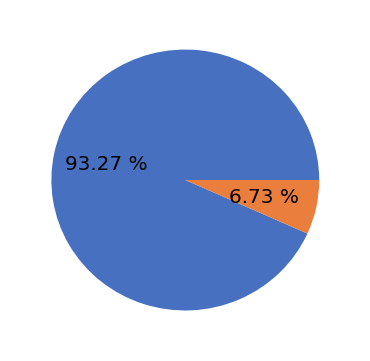

In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(         test_prediction.eval(), test_labels))    
    

Good when loss is about half of the total error produced by the function ($600$ vs $250$)

Wow, even better test accuracy.... 

# Problem 2

---
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [9]:
max_num_batches = (train_labels.shape[0] - batch_size) 
print("max number of batches: {:,}".format(max_num_batches))

max number of batches: 199,872


Initialized


Minibatch loss at step 0: 600.835449
Minibatch accuracy: 6.2%
Validation accuracy: 33.5%
Minibatch loss at step 500: 145.874298
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 1000: 88.466164
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 1500: 53.650730
Minibatch accuracy: 100.0%
Validation accuracy: 63.4%
Minibatch loss at step 2000: 32.536751
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Minibatch loss at step 2500: 19.732080
Minibatch accuracy: 100.0%
Validation accuracy: 63.6%
Minibatch loss at step 3000: 11.966666
Minibatch accuracy: 100.0%
Validation accuracy: 63.9%

Test accuracy: 70.8%


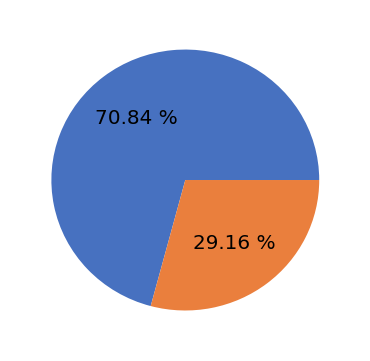

In [10]:
num_steps = 3001
batch_size = 128
num_batches = 1

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # changed -- now only three batches
        offset = (step * batch_size) % num_batches
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
        # thus, batch_data and batch_labels are subsets of this np.array. 
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}


        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))     
    isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))

Hm, interesting. It's still able to reduce its loss by reducing the norm of the weight matrices $\mathbf{W}$, but it's not able to make a significant impact on its validation accuracy in that manner, as it's only using one batch of size 128. 

# Problem 3

---

---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

## Graph

Hm, do I do this in the `tf.Session` or in the `tf.Graph`? `tf.Graph .`

In [11]:
batch_size = 128
dropout_keep_prob = 0.3

dropout_graph = tf.Graph()
with dropout_graph.as_default():
    # Input data
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    # train data: rows × columns; placeholder so can do SGD
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(
        batch_size, num_labels))  # train labels: rows × 1

    tf_valid_dataset = tf.constant(valid_dataset)  # validation data
    tf_test_dataset = tf.constant(test_dataset)

    # Variables. (Parameters); initialize.
    # not reducing dimensionality, so same number of rows as columns; initialize as normal
    weights_layer_one = tf.Variable(tf.truncated_normal(
        [image_size * image_size, image_size * image_size]))
    # one bias per feature; initialize at zero
    biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

    weights_layer_three = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases_layer_three = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Network architecture: 1024 RELUs
    layer_one_output_tensor = tf.matmul(
        tf_train_dataset, weights_layer_one) + biases_layer_one
    
    # additional dropout layer
    layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(layer_one_output_tensor, keep_prob=dropout_keep_prob))

    logits = tf.matmul(layer_two_output_tensor,
                       weights_layer_three) + biases_layer_three

    # new this time -- regularization
    beta_1 = tf.constant([0.001])
    beta_2 = tf.constant([0.001])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                        tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three)))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)
    test_prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one), weights_layer_three) + biases_layer_three)

## Session

Initialized


Minibatch loss at step 0: 800.659790
Minibatch accuracy: 11.7%
Validation accuracy: 30.3%
Minibatch loss at step 500: 181.967438
Minibatch accuracy: 60.2%
Validation accuracy: 78.5%
Minibatch loss at step 1000: 92.086472
Minibatch accuracy: 68.8%
Validation accuracy: 78.0%
Minibatch loss at step 1500: 56.048244
Minibatch accuracy: 63.3%
Validation accuracy: 79.9%
Minibatch loss at step 2000: 32.467590
Minibatch accuracy: 78.9%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 20.392408
Minibatch accuracy: 74.2%
Validation accuracy: 82.8%
Minibatch loss at step 3000: 12.247711
Minibatch accuracy: 75.8%
Validation accuracy: 83.8%

Test accuracy: 90.6%


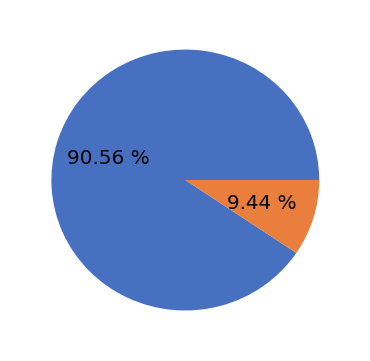

In [12]:
num_steps = 3001
batch_size = 128
num_batches = max_num_batches

with tf.Session(graph=dropout_graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in tqdm.tqdm_notebook(range(num_steps)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % num_batches

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data.
        # thus, batch_data and batch_labels are subsets of this np.array.
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels}

        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %
                  accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(
        test_prediction.eval(), test_labels))
    isajosep_util.plot_pie_percent(
        accuracy(test_prediction.eval(), test_labels))

Hm, yes,rescued 2% using 0.7 dropout, 5% using 0.5 dropout, 8% using 0.3 dropout, 2% using 0.1 dropout.  

# Problem 4
---

---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---




Initialized


Minibatch loss at step 0: 12,452.0; Minibatch accuracy: 14.1%; Validation accuracy: 9.7%
Minibatch loss at step 500: 9,845.3; Minibatch accuracy: 7.8%; Validation accuracy: 10.9%
Minibatch loss at step 1000: 9,538.3; Minibatch accuracy: 12.5%; Validation accuracy: 11.7%
Minibatch loss at step 1500: 10,252.6; Minibatch accuracy: 8.6%; Validation accuracy: 12.3%
Minibatch loss at step 2000: 9,528.3; Minibatch accuracy: 12.5%; Validation accuracy: 12.8%
Minibatch loss at step 2500: 9,701.9; Minibatch accuracy: 11.7%; Validation accuracy: 12.9%
Test accuracy: 14.0%


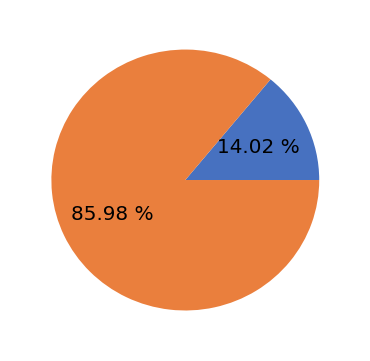

Initialized


Minibatch loss at step 0: 11,525.9; Minibatch accuracy: 10.2%; Validation accuracy: 10.5%
Minibatch loss at step 500: 9,415.0; Minibatch accuracy: 17.2%; Validation accuracy: 13.4%
Minibatch loss at step 1000: 8,208.5; Minibatch accuracy: 14.1%; Validation accuracy: 15.6%
Minibatch loss at step 1500: 8,201.5; Minibatch accuracy: 15.6%; Validation accuracy: 17.3%
Minibatch loss at step 2000: 9,026.4; Minibatch accuracy: 13.3%; Validation accuracy: 18.8%
Minibatch loss at step 2500: 8,411.4; Minibatch accuracy: 10.9%; Validation accuracy: 20.2%
Test accuracy: 22.5%


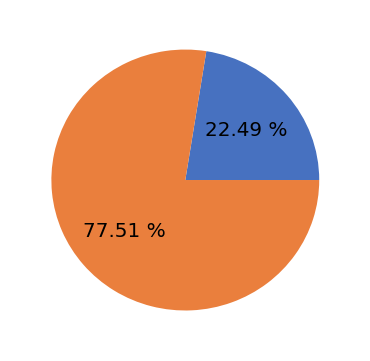

Initialized


Minibatch loss at step 0: 10,259.6; Minibatch accuracy: 8.6%; Validation accuracy: 11.8%
Minibatch loss at step 500: 9,047.4; Minibatch accuracy: 15.6%; Validation accuracy: 18.1%
Minibatch loss at step 1000: 8,271.1; Minibatch accuracy: 17.2%; Validation accuracy: 23.0%
Minibatch loss at step 1500: 7,698.1; Minibatch accuracy: 17.2%; Validation accuracy: 28.0%
Minibatch loss at step 2000: 8,095.8; Minibatch accuracy: 18.0%; Validation accuracy: 30.3%
Minibatch loss at step 2500: 7,485.1; Minibatch accuracy: 15.6%; Validation accuracy: 31.9%
Test accuracy: 35.2%


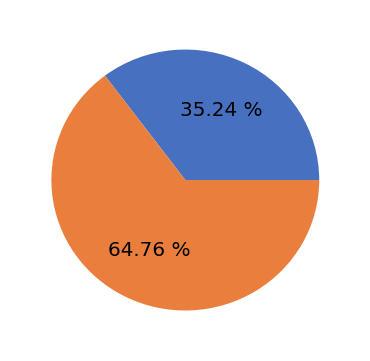

Initialized


Minibatch loss at step 0: 11,979.5; Minibatch accuracy: 5.5%; Validation accuracy: 7.3%
Minibatch loss at step 500: 8,524.3; Minibatch accuracy: 15.6%; Validation accuracy: 18.5%
Minibatch loss at step 1000: 6,518.6; Minibatch accuracy: 24.2%; Validation accuracy: 28.3%
Minibatch loss at step 1500: 6,266.1; Minibatch accuracy: 20.3%; Validation accuracy: 34.3%
Minibatch loss at step 2000: 6,910.0; Minibatch accuracy: 17.2%; Validation accuracy: 38.5%
Minibatch loss at step 2500: 6,690.1; Minibatch accuracy: 22.7%; Validation accuracy: 41.1%
Test accuracy: 47.4%


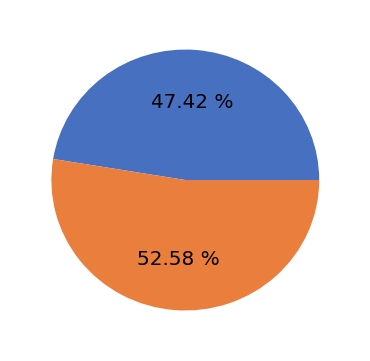

Initialized


Minibatch loss at step 0: 10,653.0; Minibatch accuracy: 17.2%; Validation accuracy: 12.1%
Minibatch loss at step 500: 7,040.6; Minibatch accuracy: 14.1%; Validation accuracy: 28.0%
Minibatch loss at step 1000: 6,196.9; Minibatch accuracy: 27.3%; Validation accuracy: 40.3%
Minibatch loss at step 1500: 5,764.1; Minibatch accuracy: 32.0%; Validation accuracy: 49.5%
Minibatch loss at step 2000: 4,484.0; Minibatch accuracy: 37.5%; Validation accuracy: 53.8%
Minibatch loss at step 2500: 5,664.9; Minibatch accuracy: 36.7%; Validation accuracy: 56.3%
Test accuracy: 64.7%


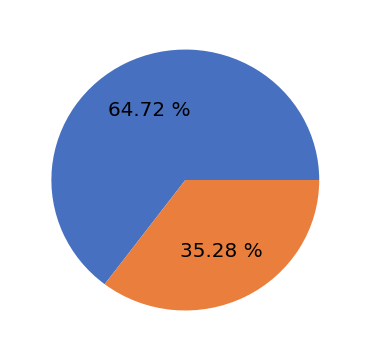

Initialized


Minibatch loss at step 0: 11,368.5; Minibatch accuracy: 5.5%; Validation accuracy: 9.9%
Minibatch loss at step 500: 6,670.7; Minibatch accuracy: 25.0%; Validation accuracy: 39.3%
Minibatch loss at step 1000: 4,636.1; Minibatch accuracy: 37.5%; Validation accuracy: 53.1%
Minibatch loss at step 1500: 5,202.0; Minibatch accuracy: 27.3%; Validation accuracy: 59.3%
Minibatch loss at step 2000: 3,909.2; Minibatch accuracy: 44.5%; Validation accuracy: 62.0%
Minibatch loss at step 2500: 3,940.1; Minibatch accuracy: 47.7%; Validation accuracy: 63.6%
Test accuracy: 71.9%


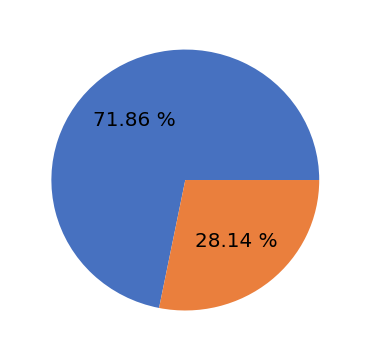

Initialized


Minibatch loss at step 0: 10,424.1; Minibatch accuracy: 8.6%; Validation accuracy: 12.3%
Minibatch loss at step 500: 5,081.9; Minibatch accuracy: 32.8%; Validation accuracy: 57.7%
Minibatch loss at step 1000: 4,340.8; Minibatch accuracy: 47.7%; Validation accuracy: 66.2%
Minibatch loss at step 1500: 4,185.2; Minibatch accuracy: 43.0%; Validation accuracy: 69.4%
Minibatch loss at step 2000: 4,099.7; Minibatch accuracy: 43.8%; Validation accuracy: 70.8%
Minibatch loss at step 2500: 3,711.4; Minibatch accuracy: 50.8%; Validation accuracy: 71.6%
Test accuracy: 79.2%


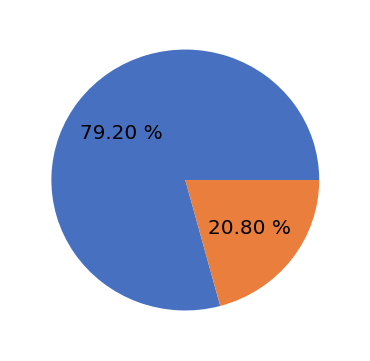

Initialized


Minibatch loss at step 0: 12,513.5; Minibatch accuracy: 9.4%; Validation accuracy: 10.5%
Minibatch loss at step 500: 5,222.3; Minibatch accuracy: 43.0%; Validation accuracy: 63.8%
Minibatch loss at step 1000: 3,797.2; Minibatch accuracy: 52.3%; Validation accuracy: 70.2%
Minibatch loss at step 1500: 3,117.4; Minibatch accuracy: 61.7%; Validation accuracy: 72.3%
Minibatch loss at step 2000: 3,227.2; Minibatch accuracy: 57.0%; Validation accuracy: 73.7%
Minibatch loss at step 2500: 3,303.5; Minibatch accuracy: 57.8%; Validation accuracy: 74.4%
Test accuracy: 82.5%


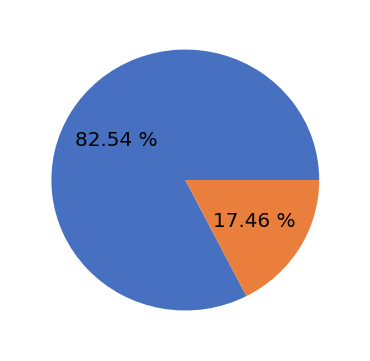

Initialized


Minibatch loss at step 0: 12,594.6; Minibatch accuracy: 6.2%; Validation accuracy: 8.1%
Minibatch loss at step 500: 3,722.7; Minibatch accuracy: 46.9%; Validation accuracy: 68.0%
Minibatch loss at step 1000: 3,451.4; Minibatch accuracy: 55.5%; Validation accuracy: 73.5%
Minibatch loss at step 1500: 2,777.1; Minibatch accuracy: 55.5%; Validation accuracy: 75.0%
Minibatch loss at step 2000: 3,301.2; Minibatch accuracy: 59.4%; Validation accuracy: 75.8%
Minibatch loss at step 2500: 2,962.7; Minibatch accuracy: 60.2%; Validation accuracy: 76.3%
Test accuracy: 84.6%


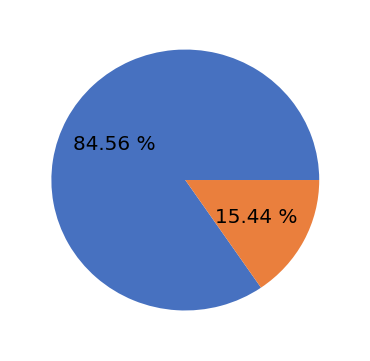

Initialized


Minibatch loss at step 0: 12,670.4; Minibatch accuracy: 7.0%; Validation accuracy: 8.7%
Minibatch loss at step 500: 4,071.2; Minibatch accuracy: 54.7%; Validation accuracy: 73.8%
Minibatch loss at step 1000: 2,311.5; Minibatch accuracy: 68.0%; Validation accuracy: 76.7%
Minibatch loss at step 1500: 2,557.4; Minibatch accuracy: 58.6%; Validation accuracy: 77.7%
Minibatch loss at step 2000: 3,139.0; Minibatch accuracy: 64.1%; Validation accuracy: 78.1%
Minibatch loss at step 2500: 2,660.2; Minibatch accuracy: 64.1%; Validation accuracy: 78.5%
Test accuracy: 86.5%


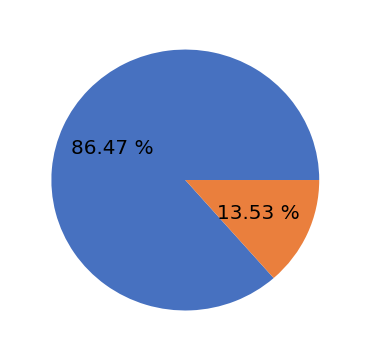

Initialized


Minibatch loss at step 0: 10,556.3; Minibatch accuracy: 12.5%; Validation accuracy: 15.1%
Minibatch loss at step 500: 3,420.3; Minibatch accuracy: 61.7%; Validation accuracy: 76.5%
Minibatch loss at step 1000: 2,287.1; Minibatch accuracy: 69.5%; Validation accuracy: 78.6%
Minibatch loss at step 1500: 2,404.3; Minibatch accuracy: 64.8%; Validation accuracy: 79.5%
Minibatch loss at step 2000: 2,203.5; Minibatch accuracy: 64.1%; Validation accuracy: 79.8%
Minibatch loss at step 2500: 2,531.3; Minibatch accuracy: 64.1%; Validation accuracy: 80.1%
Test accuracy: 87.6%


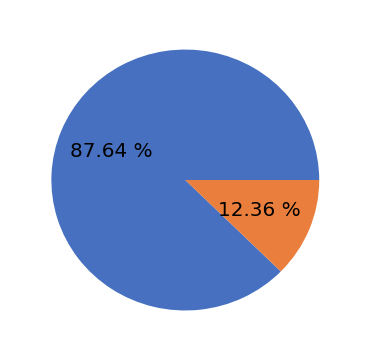

Initialized


Minibatch loss at step 0: 9,511.3; Minibatch accuracy: 10.2%; Validation accuracy: 7.9%
Minibatch loss at step 500: 3,127.5; Minibatch accuracy: 61.7%; Validation accuracy: 78.7%
Minibatch loss at step 1000: 1,750.2; Minibatch accuracy: 72.7%; Validation accuracy: 80.3%
Minibatch loss at step 1500: 2,014.9; Minibatch accuracy: 69.5%; Validation accuracy: 81.0%
Minibatch loss at step 2000: 2,017.9; Minibatch accuracy: 67.2%; Validation accuracy: 81.3%
Minibatch loss at step 2500: 2,489.8; Minibatch accuracy: 66.4%; Validation accuracy: 81.3%
Test accuracy: 88.5%


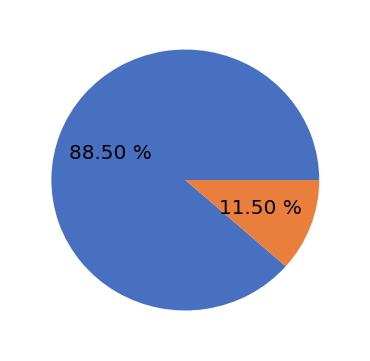

Initialized


Minibatch loss at step 0: 9,824.5; Minibatch accuracy: 12.5%; Validation accuracy: 11.7%
Minibatch loss at step 500: 2,487.1; Minibatch accuracy: 68.8%; Validation accuracy: 79.2%
Minibatch loss at step 1000: 1,961.0; Minibatch accuracy: 71.1%; Validation accuracy: 80.6%
Minibatch loss at step 1500: 1,822.1; Minibatch accuracy: 70.3%; Validation accuracy: 81.3%
Minibatch loss at step 2000: 1,915.8; Minibatch accuracy: 69.5%; Validation accuracy: 81.6%
Minibatch loss at step 2500: 2,028.3; Minibatch accuracy: 68.8%; Validation accuracy: 81.9%
Test accuracy: 89.4%


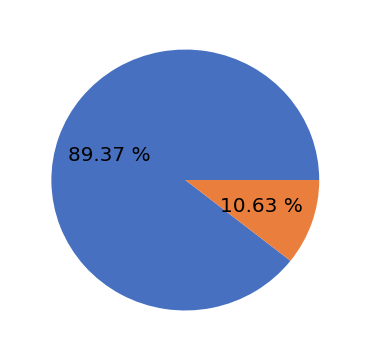

Initialized


Minibatch loss at step 0: 11,332.2; Minibatch accuracy: 11.7%; Validation accuracy: 10.2%
Minibatch loss at step 500: 2,548.2; Minibatch accuracy: 67.2%; Validation accuracy: 81.1%
Minibatch loss at step 1000: 1,425.4; Minibatch accuracy: 70.3%; Validation accuracy: 82.0%
Minibatch loss at step 1500: 1,445.1; Minibatch accuracy: 67.2%; Validation accuracy: 82.5%
Minibatch loss at step 2000: 1,309.1; Minibatch accuracy: 72.7%; Validation accuracy: 82.8%
Minibatch loss at step 2500: 1,225.2; Minibatch accuracy: 70.3%; Validation accuracy: 83.2%
Test accuracy: 90.0%


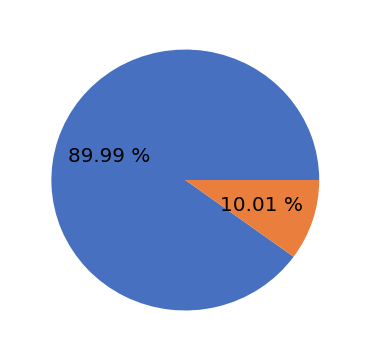

Initialized


Minibatch loss at step 0: 12,463.4; Minibatch accuracy: 7.8%; Validation accuracy: 13.4%
Minibatch loss at step 500: 1,903.6; Minibatch accuracy: 68.0%; Validation accuracy: 81.9%
Minibatch loss at step 1000: 1,061.1; Minibatch accuracy: 77.3%; Validation accuracy: 82.8%
Minibatch loss at step 1500: 1,061.1; Minibatch accuracy: 71.9%; Validation accuracy: 83.1%
Minibatch loss at step 2000: 1,020.9; Minibatch accuracy: 80.5%; Validation accuracy: 83.0%
Minibatch loss at step 2500: 955.1; Minibatch accuracy: 77.3%; Validation accuracy: 83.6%
Test accuracy: 90.5%


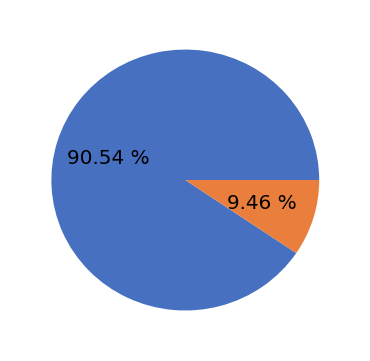

Initialized


Minibatch loss at step 0: 11,930.0; Minibatch accuracy: 6.2%; Validation accuracy: 16.7%
Minibatch loss at step 500: 1,402.5; Minibatch accuracy: 71.1%; Validation accuracy: 82.4%
Minibatch loss at step 1000: 948.1; Minibatch accuracy: 76.6%; Validation accuracy: 82.9%
Minibatch loss at step 1500: 895.9; Minibatch accuracy: 75.0%; Validation accuracy: 83.1%
Minibatch loss at step 2000: 796.9; Minibatch accuracy: 79.7%; Validation accuracy: 83.5%
Minibatch loss at step 2500: 807.9; Minibatch accuracy: 73.4%; Validation accuracy: 83.8%
Test accuracy: 90.2%


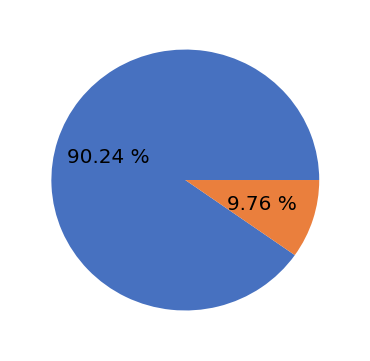

Initialized


Minibatch loss at step 0: 9,969.7; Minibatch accuracy: 12.5%; Validation accuracy: 28.1%
Minibatch loss at step 500: 1,322.2; Minibatch accuracy: 67.2%; Validation accuracy: 82.0%
Minibatch loss at step 1000: 755.1; Minibatch accuracy: 76.6%; Validation accuracy: 83.2%
Minibatch loss at step 1500: 764.6; Minibatch accuracy: 73.4%; Validation accuracy: 83.8%
Minibatch loss at step 2000: 663.7; Minibatch accuracy: 75.8%; Validation accuracy: 83.5%
Minibatch loss at step 2500: 643.7; Minibatch accuracy: 71.1%; Validation accuracy: 84.3%
Test accuracy: 90.2%


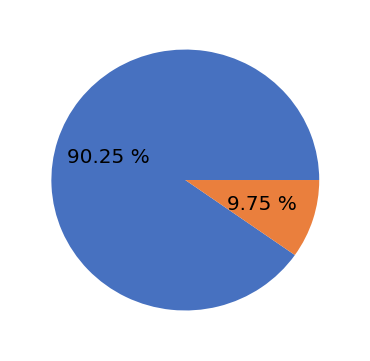

Initialized


Minibatch loss at step 0: 11,371.2; Minibatch accuracy: 10.2%; Validation accuracy: 27.5%
Minibatch loss at step 500: 1,045.0; Minibatch accuracy: 74.2%; Validation accuracy: 81.5%
Minibatch loss at step 1000: 672.1; Minibatch accuracy: 78.1%; Validation accuracy: 82.5%
Minibatch loss at step 1500: 661.3; Minibatch accuracy: 71.1%; Validation accuracy: 82.6%
Minibatch loss at step 2000: 591.8; Minibatch accuracy: 79.7%; Validation accuracy: 82.2%
Minibatch loss at step 2500: 570.1; Minibatch accuracy: 74.2%; Validation accuracy: 83.2%
Test accuracy: 89.9%


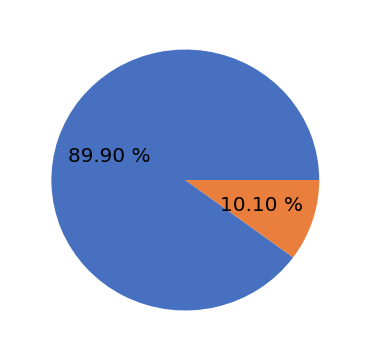

Initialized


Minibatch loss at step 0: 10,242.0; Minibatch accuracy: 10.9%; Validation accuracy: 24.5%
Minibatch loss at step 500: 947.5; Minibatch accuracy: 70.3%; Validation accuracy: 81.8%
Minibatch loss at step 1000: 673.4; Minibatch accuracy: 70.3%; Validation accuracy: 82.2%
Minibatch loss at step 1500: 609.3; Minibatch accuracy: 68.8%; Validation accuracy: 81.8%
Minibatch loss at step 2000: 567.1; Minibatch accuracy: 77.3%; Validation accuracy: 82.5%
Minibatch loss at step 2500: 552.7; Minibatch accuracy: 76.6%; Validation accuracy: 82.4%
Test accuracy: 89.4%


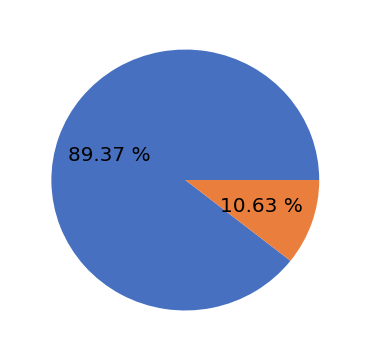

Initialized


Minibatch loss at step 0: 9,940.5; Minibatch accuracy: 8.6%; Validation accuracy: 33.8%
Minibatch loss at step 500: 925.9; Minibatch accuracy: 70.3%; Validation accuracy: 80.9%
Minibatch loss at step 1000: 601.7; Minibatch accuracy: 75.8%; Validation accuracy: 81.1%
Minibatch loss at step 1500: 604.7; Minibatch accuracy: 71.9%; Validation accuracy: 81.2%
Minibatch loss at step 2000: 558.1; Minibatch accuracy: 78.1%; Validation accuracy: 80.9%
Minibatch loss at step 2500: 546.6; Minibatch accuracy: 68.0%; Validation accuracy: 81.1%
Test accuracy: 88.8%


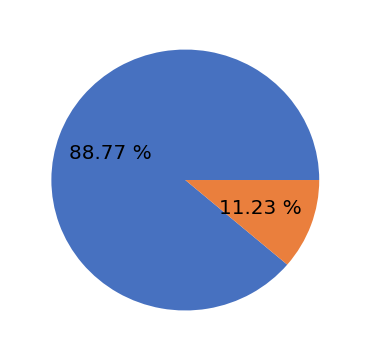

In [71]:
# Grid search params

test_accuracies = []
learning_rate_inits = np.logspace(start=-6,stop=-2, num=20)

for learning_rate_init_probe in tqdm.tqdm_notebook(learning_rate_inits):
    # params
    batch_size = 128
    dropout_keep_prob = 0.5
#    learning_rate_init = 0.001
    decay_steps = 1000
    decay_rate = 0.5
    beta_1_value = 1e-3
    beta_2_value = 1e-3
    beta_3_value = 1e-3

    best_possible_graph = tf.Graph()
    with best_possible_graph.as_default():
        # Input data
        # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        # train data: rows × columns; placeholder so can do SGD
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(
            batch_size, num_labels))  # train labels: rows × 1

        tf_valid_dataset = tf.constant(valid_dataset)  # validation data
        tf_test_dataset = tf.constant(test_dataset)

        ############################## Variables. (Parameters); initialize.
        # not reducing dimensionality, so same number of rows as columns; initialize as normal

        # W₁: (number_of_pixels_per_image × number_of_pixels_per_image)
        # b₁: (number_of_pixels_per_image × 1)    
        weights_layer_one = tf.Variable(tf.truncated_normal(
            [image_size * image_size, image_size * image_size]))
        # one bias per feature; initialize at zero
        biases_layer_one = tf.Variable(tf.zeros([image_size * image_size]))

        # W₂: (number_of_pixels_per_image × number_of_pixels_per_image)
        # b₂: (number_of_pixels_per_image × 1)
        weights_layer_three = tf.Variable(
            tf.truncated_normal([image_size * image_size, image_size * image_size]))
        biases_layer_three = tf.Variable(tf.zeros([image_size * image_size]))

        # W₃: (number_of_pixels_per_image × num_labels(=10))
        # b₃: (num_labels(=10) × 1)
        weights_layer_four = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]))
        biases_layer_four = tf.Variable(tf.zeros([num_labels]))

        ############################## Training computation (layer specification using variables above and other methods).

        #  layer 1 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_one_output_tensor = tf.matmul(
            tf_train_dataset, weights_layer_one) + biases_layer_one 

        # additional dropout/ RELU layer
        # layer 2 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_two_output_tensor = tf.nn.relu(tf.nn.dropout(
            layer_one_output_tensor, keep_prob=dropout_keep_prob)) 

        #  additional regular layer
        # layer 3 : (n_train × number_of_pixels_per_image)  → (n_train × number_of_pixels_per_image)
        layer_three_output_tensor = tf.matmul(layer_two_output_tensor, weights_layer_three) + biases_layer_three  

        # output:  (n_train × number_of_pixels_per_image)  → (n_train × num_labels(=10))
        logits = tf.matmul(layer_three_output_tensor,
                           weights_layer_four) + biases_layer_four

        ############################## Objective function
        # Regularization of *weights*: objective + β₁‖W₁‖₂ + β₂‖W₂‖₂ + β₃‖W₃‖₂
        beta_1 = tf.constant([beta_1_value])
        beta_2 = tf.constant([beta_2_value])
        beta_3 = tf.constant([beta_3_value])
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + tf.multiply(beta_1,
                                                                                                                            tf.reduce_mean(tf.nn.l2_loss(weights_layer_one))) + tf.multiply(beta_2, tf.reduce_mean(tf.nn.l2_loss(weights_layer_three))) + tf.multiply(beta_3, tf.reduce_mean(tf.nn.l2_loss(weights_layer_four)))

        ############################## Optimizer
        global_step = tf.Variable(0)  # initialize as 1 × 1 vector (scalar) = 0; # a scalar Tensor of the same type as `learning_rate` (in this case, float64)

        learning_rate = tf.train.exponential_decay(learning_rate=learning_rate_init_probe, 
                                                   global_step=global_step, 
                                                   decay_steps=decay_steps,
                                                   decay_rate=decay_rate, 
                                                   staircase=False)  

        # Exponential decay: decayed_learning_rate = learning_rate *
        #                         decay_rate ^ (global_step / decay_steps)
        # if staircase=True, decay steps is how many steps before decay kicks in. Higher value ⇒ lower rate of decay; otherwise, this is done at every step

        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
            loss=loss, global_step=global_step)  # will global_step be updated?

        #     optimzer = tf.train.AdamOptimizer().minimize(loss=loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_valid_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)
        test_prediction = tf.nn.softmax(tf.matmul((tf.matmul(tf.nn.relu((tf.matmul(tf_test_dataset, weights_layer_one) + biases_layer_one)), weights_layer_three) + biases_layer_three), weights_layer_four) + biases_layer_four)

        ########################################################################################################################################################################################################
        ############################################################################################## Run Graph ###############################################################################################
        ########################################################################################################################################################################################################

        num_steps = 3000
        num_batches = (train_labels.shape[0] - batch_size)  # Max number of possible batches: all possible starting positions in the training set


        with tf.Session(graph=best_possible_graph) as session:
            tf.global_variables_initializer().run()
            print("Initialized")
            for step in tqdm.tqdm_notebook(range(num_steps)):
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (step * batch_size)  % num_batches 

                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]

                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                # tf_train_dataset is a tf.placeholder-created Tensor, whereas train_dataset is the actual np.array of training data. 
                # thus, batch_data and batch_labels are subsets of this np.array. 
                feed_dict = {tf_train_dataset: batch_data,
                             tf_train_labels: batch_labels}


                _, l, predictions = session.run(
                    [optimizer, loss, train_prediction], feed_dict=feed_dict)

                if (step % 500 == 0):
                    print("Minibatch loss at step {}: {:,.1f}".format(step, l[0]), end='; ')
                    print("Minibatch accuracy: %.1f%%" %
                          accuracy(predictions, batch_labels), end='; ' )
                    print("Validation accuracy: %.1f%%" % accuracy(
                        valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(
                test_prediction.eval(), test_labels))     
            isajosep_util.plot_pie_percent(accuracy(test_prediction.eval(), test_labels))
            test_accuracies += [accuracy(test_prediction.eval(), test_labels)]



Hm, larger batch size doesn't necessarily matter for accuracy after a certain point (has diminishing returns). However, it takes much longer. 

In [72]:
import isajosep_util

(0, 0.00015)

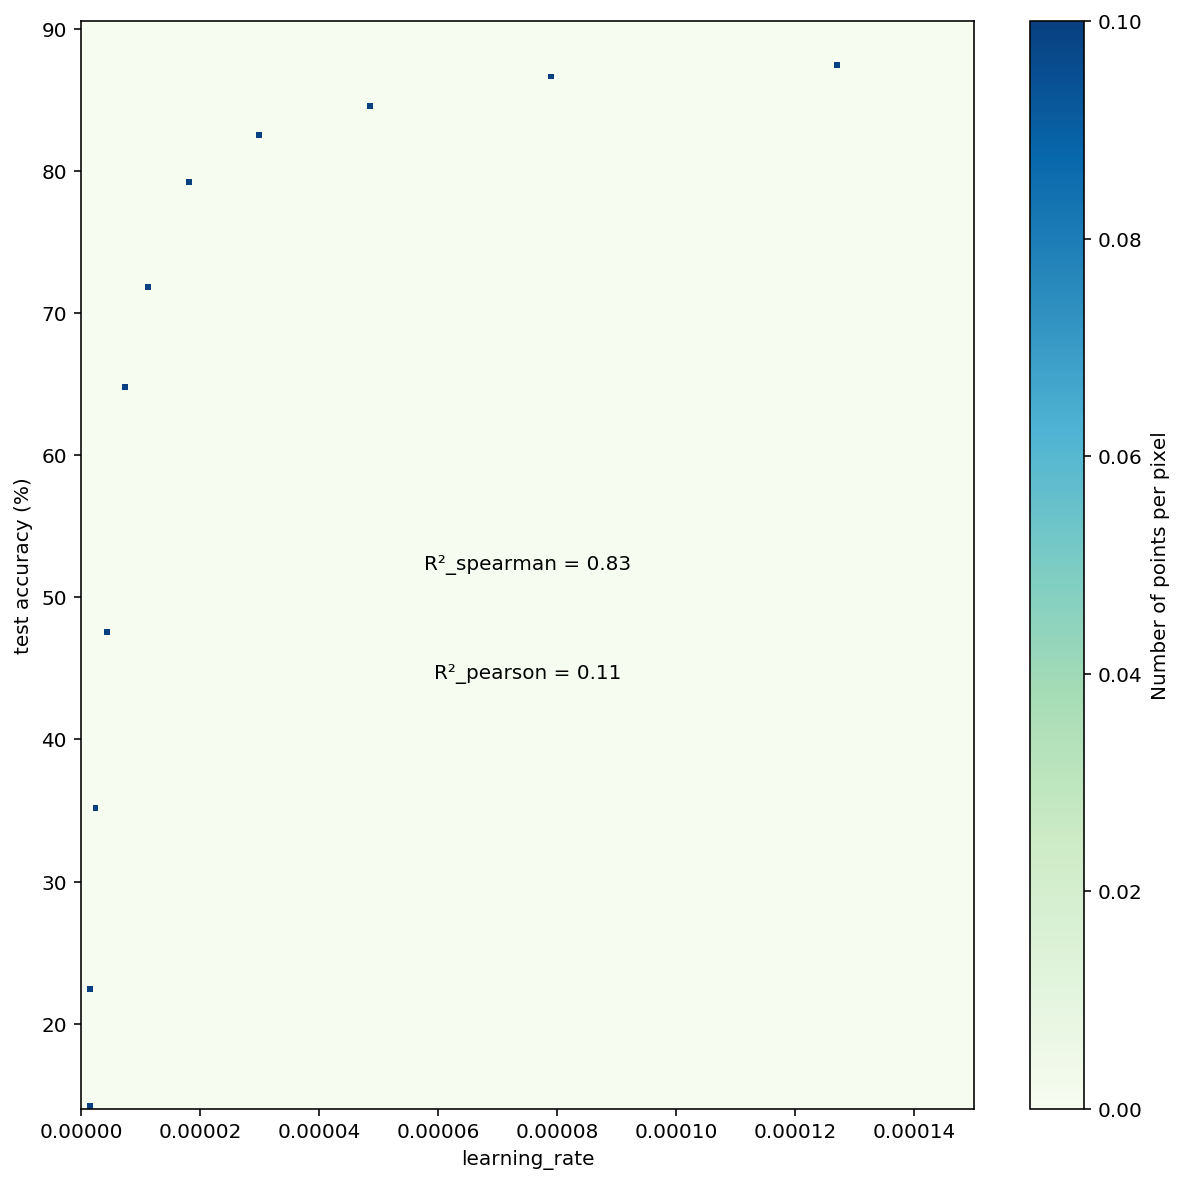

In [78]:
ax, fig = isajosep_util.data_frame_plotter.mpl_scatter_density_from_df(learning_rate_inits, test_accuracies, dpi=30)
ax.set_xlabel("learning_rate")
ax.set_ylabel("test accuracy (%)")
ax.set_xlim(0,1.5e-4)

About $1.5 × 10^{-4 }$is optimal `learning_rate_init`. Before that it underfits (probably doesn't reach maximum possible after the number of steps used); after that, it seems like it may overfit. 

⇒ maybe consider lowering `learning_rate_init`, but increasing number of iterations?  